In [61]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler,PowerTransformer
from tqdm import tqdm
import lightgbm as lgb
from pykalman import KalmanFilter
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error

In [48]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [49]:
df = pd.read_csv('data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df = df.set_index('Ngày')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Ngày,,,,,,,,,,,,,,,,,,,,,
01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [50]:
msv = 2151260835
msv%16 + 1  

4

In [51]:
data = df[['4','5','6']]
data

,4,5,6
Ngày,,,
01/01/2021,964.4,964.4,964.4
01/02/2021,1019.7,1019.7,1019.7
01/03/2021,988.4,988.4,988.4
01/04/2021,1002.0,1002.0,1002.0
01/05/2021,1061.5,1061.5,1061.5
...,...,...,...
27/12/2021,1002.0,1002.0,1002.0
28/12/2021,1002.0,1002.0,1002.0
29/12/2021,1061.5,1061.5,1061.5


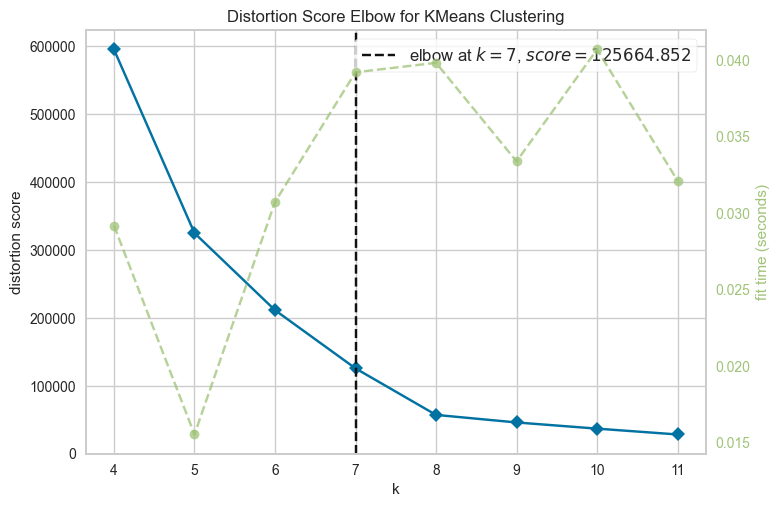

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

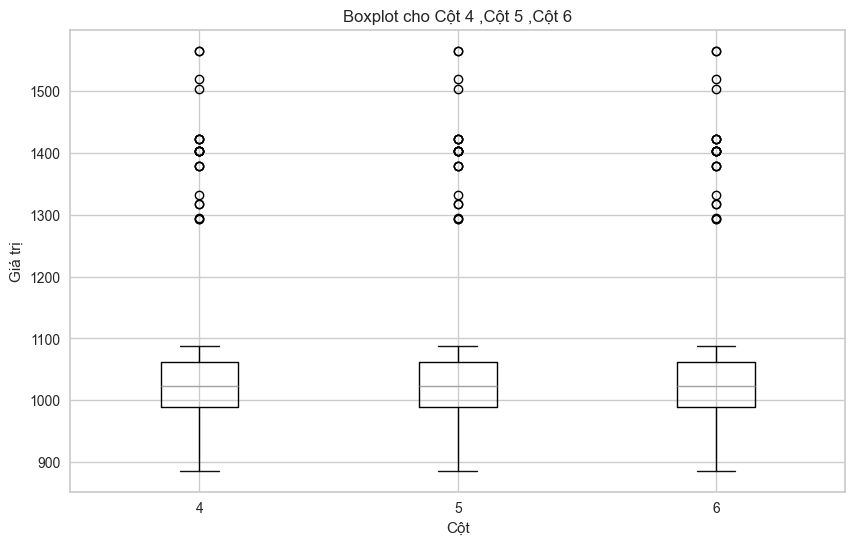

In [53]:
# Tạo boxplot cho cả hai cột
plt.figure(figsize=(10, 6))
data.boxplot()

# Thêm tiêu đề và nhãn trục
plt.title('Boxplot cho Cột 4 ,Cột 5 ,Cột 6')
plt.ylabel('Giá trị')
plt.xlabel('Cột')
plt.show()

<Axes: title={'center': 'Heatmap of Correlation Matrix'}>

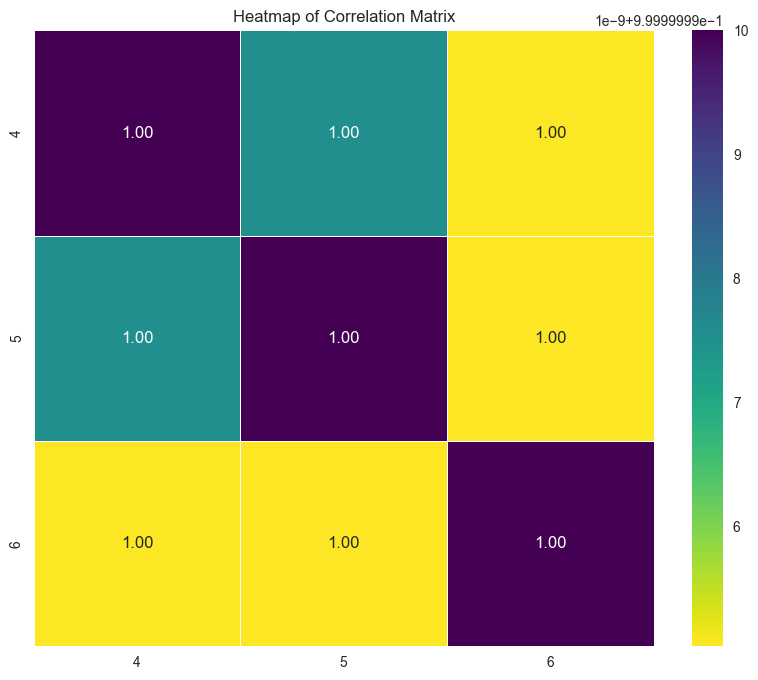

In [54]:
corr_matrix = data.corr()
plt.figure(figsize=(10,8))
plt.title('Heatmap of Correlation Matrix')
sns.heatmap(corr_matrix, annot=True,linewidths=0.5,fmt='.2f', cmap="viridis_r")

ConversionError: Failed to convert value(s) to axis units: DatetimeIndex([          '2021-01-01 00:00:00',
               '2021-01-18 06:51:25.714285714',
               '2021-02-04 13:42:51.428571428',
               '2021-02-21 20:34:17.142857143',
               '2021-03-11 03:25:42.857142857',
               '2021-03-28 10:17:08.571428571',
               '2021-04-14 17:08:34.285714286',
                         '2021-05-02 00:00:00',
               '2021-05-19 06:51:25.714285714',
               '2021-06-05 13:42:51.428571428',
               '2021-06-22 20:34:17.142857142',
               '2021-07-10 03:25:42.857142856',
               '2021-07-27 10:17:08.571428572',
               '2021-08-13 17:08:34.285714284',
                         '2021-08-31 00:00:00'],
              dtype='datetime64[ns]', freq=None)

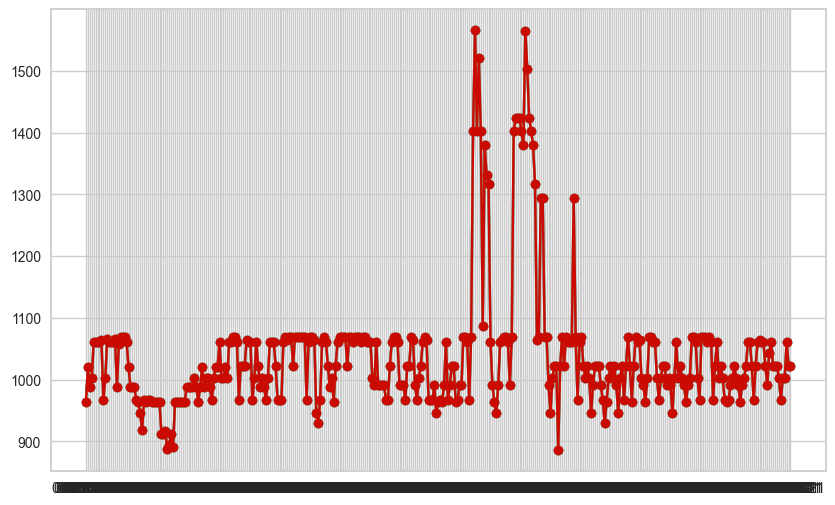

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['4'],marker='o',label='4', linestyle='-')
plt.plot(data.index, data['5'],marker='o', label='5',linestyle='-')
plt.plot(data.index, data['6'],marker='o',label='6', linestyle='-')

x_ticks = pd.date_range(start=data.index.min(), end=data.index.max(),periods=15)
plt.xticks(ticks=x_ticks, labels=x_ticks.strftime('%Y-%m'))

y_ticks = np.linspace(data['4'].min(), data['4'].max(), 20)
plt.yticks(ticks=y_ticks)

formatter = mticker.FuncFormatter(lambda x, pos: f'{int(x/1e3)}N')
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('biểu đồ')
plt.xlabel('Thời gian')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

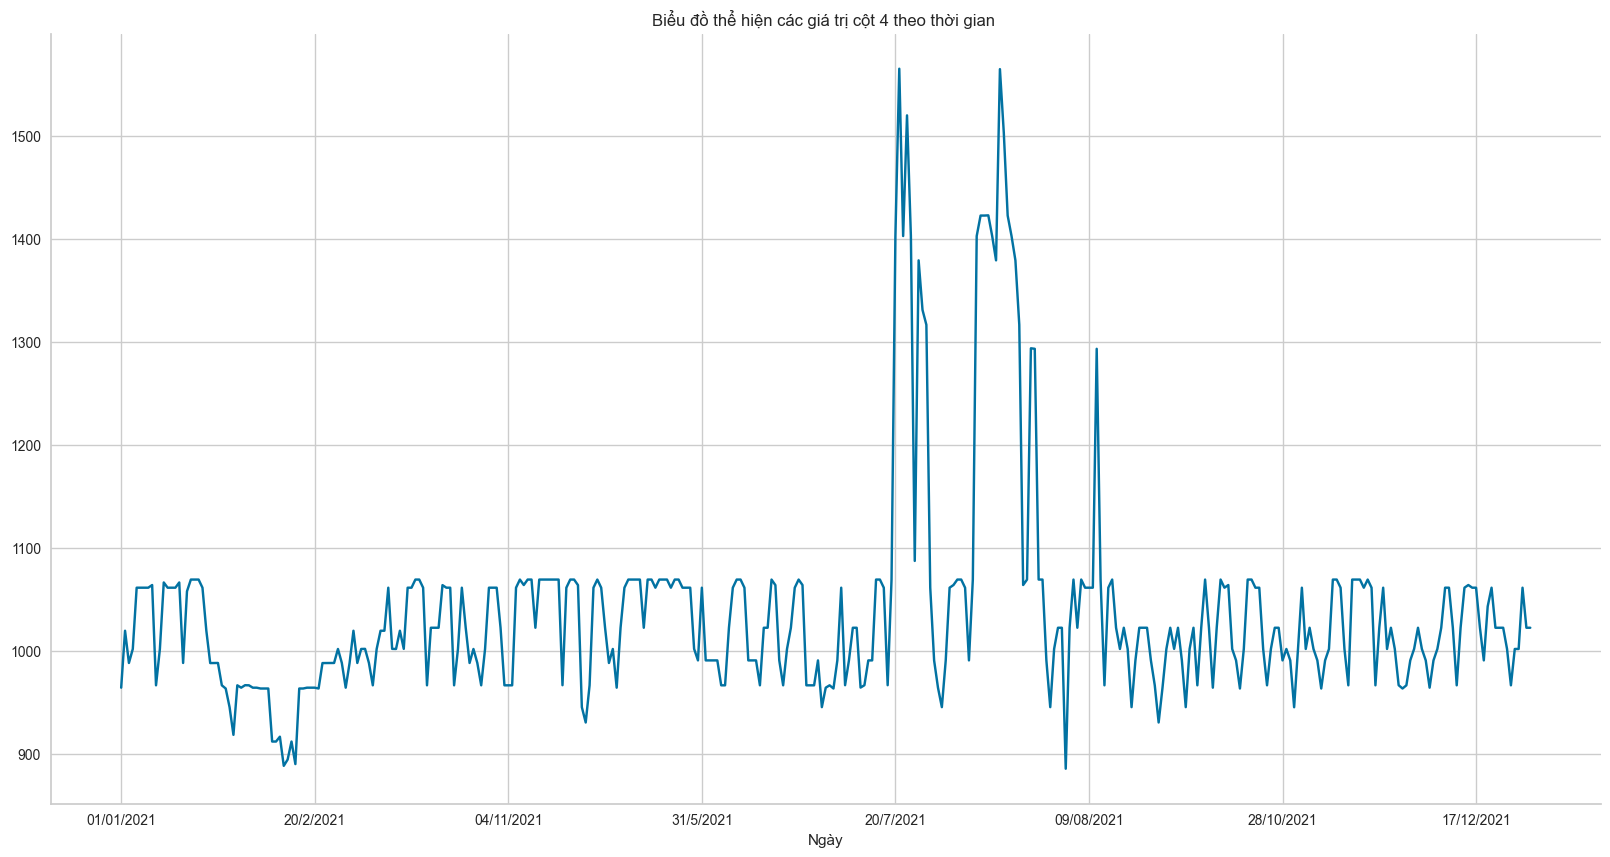

In [ ]:
plt.figure(figsize=(20,10))
df['4'].plot(kind='line',figsize=(20,10),title="Biểu đồ thể hiện các giá trị cột 4 theo thời gian ")
plt.gca().spines[['top','right']].set_visible(False)

### Các Model

BayesianGaussianMixture

In [ ]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
bgm_preds = BGM.fit_predict(data)

In [ ]:
pp=BGM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new1=pd.DataFrame(data) 
df_new1[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new1['preds']=bgm_preds
df_new1['predict_proba']=np.max(pp,axis=1)
df_new1['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new1[(df_new1.preds==n) & (df_new1.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [ ]:
from sklearn.model_selection import StratifiedKFold
X_new1=df_new1.loc[train_index]
y=df_new1.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new1,y)):   

    tr_dataset = lgb.Dataset(X_new1.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new1.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 4.45713e-05
[400]	valid_0's multi_logloss: 4.45713e-05
[200]	valid_0's multi_logloss: 5.93843e-06
[400]	valid_0's multi_logloss: 5.93843e-06
[200]	valid_0's multi_logloss: 4.83613e-06
[400]	valid_0's multi_logloss: 4.83613e-06
[200]	valid_0's multi_logloss: 5.25628e-06
[400]	valid_0's multi_logloss: 5.25628e-06
[200]	valid_0's multi_logloss: 4.78616e-06
[400]	valid_0's multi_logloss: 4.78616e-06
[200]	valid_0's multi_logloss: 4.75935e-06
[400]	valid_0's multi_logloss: 4.75935e-06
[200]	valid_0's multi_logloss: 5.05818e-06
[400]	valid_0's multi_logloss: 5.05818e-06
[200]	valid_0's multi_logloss: 7.52575e-06
[400]	valid_0's multi_logloss: 7.52575e-06
[200]	valid_0's multi_logloss: 8.97216e-06
[400]	valid_0's multi_logloss: 8.97216e-06
[200]	valid_0's multi_logloss: 7.60589e-06
[400]	valid_0's multi_logloss: 7.60589e-06
[200]	valid_0's multi_logloss: 1.29323e-05
[400]	valid_0's multi_logloss: 1.29323e-05


In [ ]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new1)

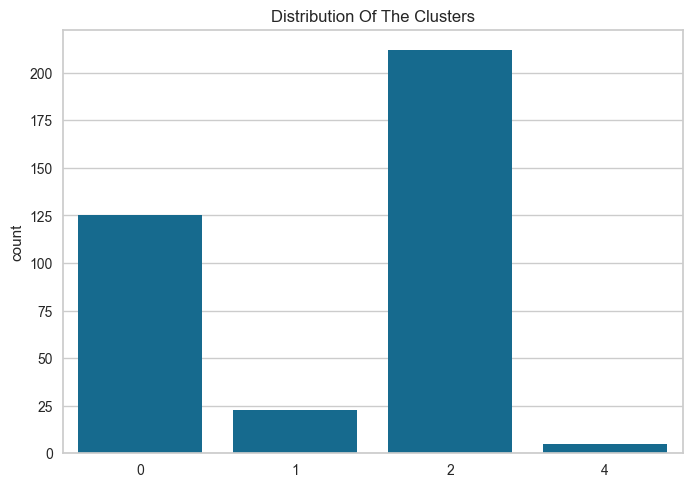

In [ ]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

Kalman filter

In [59]:
# Tạo ma trận dữ liệu đo lường
z = data[['4', '5', '6']].values.T

# Khởi tạo Kalman Filter
kf = KalmanFilter(dim_x=1, dim_z=3)

# Tinh chỉnh ma trận 
kf.F = np.array([[1]])  # Ma trận chuyển đổi trạng thái
kf.H = np.array([[1], [1], [1]])  # Ma trận quan sát (3,1)

# Điều chỉnh ma trận hiệp phương sai
kf.Q = np.array([[0.01]])  # Giảm nhiễu quá trình 
kf.R = np.array([[2, 0, 0],  # Tăng nhiễu đo lường 
                  [0, 2, 0],
                  [0, 0, 2]])  

# Khởi tạo trạng thái ban đầu
kf.x = np.array([[np.mean(z[:, 0])]])
kf.P = np.array([[1]])

# Kalman Filter
x_hat_list = []
for k in range(z.shape[1]):
    kf.predict()
    kf.update(z[:, k])
    x_hat_list.append(kf.x[0, 0])

# Thêm cột ước lượng vào DataFrame
data['kalman_estimate'] = x_hat_list

# Đánh giá hiệu suất
rmse = np.sqrt(mean_squared_error(data[['4', '5', '6']].mean(axis=1), data['kalman_estimate']))
print(f"RMSE của Kalman Filter: {rmse}")

# In DataFrame
print(data)

RMSE của Kalman Filter: 73.82931896311068
                 4       5       6     4_kalman     5_kalman     6_kalman  \
Ngày                                                                        
01/01/2021   964.4   964.4   964.4   607.508112   607.508112   607.508112   
01/02/2021  1019.7  1019.7  1019.7   858.124337   858.124337   858.124337   
01/03/2021   988.4   988.4   988.4   947.164898   947.164898   947.164898   
01/04/2021  1002.0  1002.0  1002.0   994.970358   994.970358   994.970358   
01/05/2021  1061.5  1061.5  1061.5  1035.746175  1035.746175  1035.746175   
...            ...     ...     ...          ...          ...          ...   
27/12/2021  1002.0  1002.0  1002.0  1001.587070  1001.587070  1001.587070   
28/12/2021  1002.0  1002.0  1002.0  1012.409762  1012.409762  1012.409762   
29/12/2021  1061.5  1061.5  1061.5  1033.642216  1033.642216  1033.642216   
30/12/2021  1022.6  1022.6  1022.6  1027.016886  1027.016886  1027.016886   
31/12/2021  1022.6  1022.6  1022.6

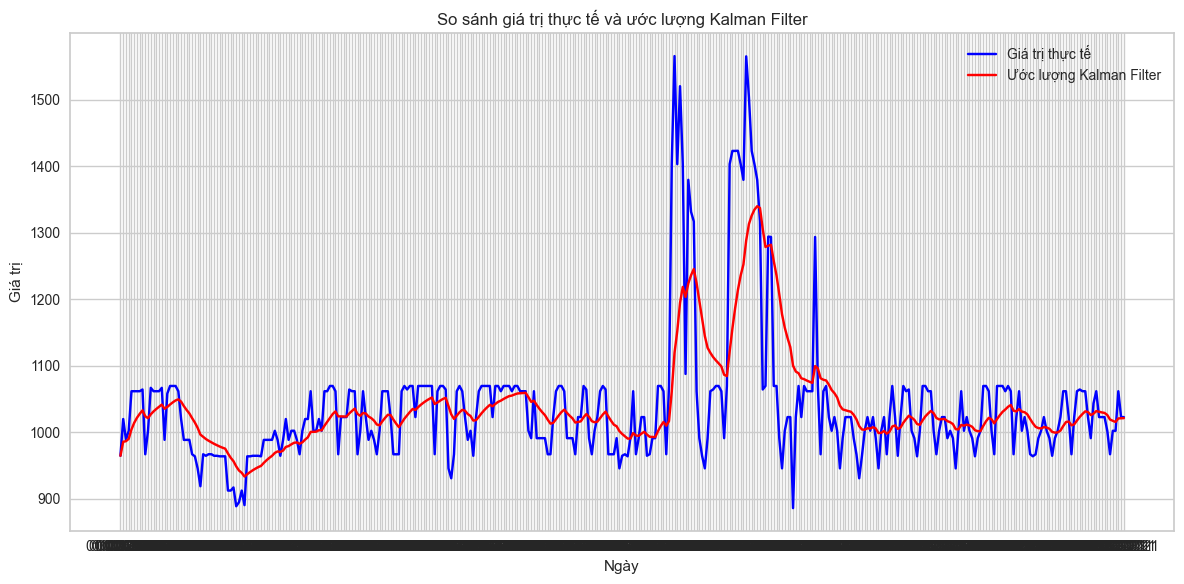

In [60]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[['4', '5', '6']].mean(axis=1), label='Giá trị thực tế', color='blue')
plt.plot(data.index, data['kalman_estimate'], label='Ước lượng Kalman Filter', color='red')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị thực tế và ước lượng Kalman Filter')
plt.legend()
plt.tight_layout()
plt.show()